In [58]:
import pandas as pd
import pybedtools
import pysam
import matplotlib.pyplot as plt
import numpy as np
import math

import os
import json
from basenji import dataset, dna_io, seqnn
import scipy.stats as stats
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from mpl_toolkits.axisartist.grid_finder import DictFormatter
from matplotlib.patches import Rectangle

In [94]:
def get_1KGseq(chr, window_start, ind):
    pop = ind.split('_')[0]
    id = ind.split('_')[3]
    fasta_open = pysam.Fastafile('/wynton/group/capra/projects/modern_human_3Dgenome/data/genomes/1KG/%s/%s/%s_%s_hg38_full.fa' % (pop, ind, chr, id))

    seq = fasta_open.fetch(chr, int(window_start), int(window_start)+2**20).upper()

    return seq

def get_anc_seq(chr, window_start):
    anc_fasta_open = pysam.Fastafile('genomes/human_archaic_ancestor/human_archaic_ancestor_in_hg38_%s.fasta' % chr)

    anc_seq = anc_fasta_open.fetch(chr, int(window_start), int(window_start)+2**20).upper()

    return anc_seq

def get_ref_seq_hg38(chr, window_start):
    ref_fasta_open = pysam.Fastafile('genomes/hg38/hg38_reference.fa')

    ref_seq = ref_fasta_open.fetch(chr, int(window_start), int(window_start)+2**20).upper()

    return ref_seq

def loadAkita():
    os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

    import tensorflow as tf
    if tf.__version__[0] == '1':
        tf.compat.v1.enable_eager_execution()

    with open('basenji/manuscripts/akita/params.json') as params_file:
        params = json.load(params_file)
        params_model = params['model']
        params_train = params['train']
        
    global seqnn_model
    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore('basenji/manuscripts/akita/model_best.h5')

def runAkitaPreds(seq):
    if len(seq) != 2**20: raise ValueError('len(seq) != seq_length')
    seq_1hot = dna_io.dna_1hot(seq)
    test_pred_from_seq = seqnn_model.model.predict(np.expand_dims(seq_1hot,0))
    return test_pred_from_seq

def visualize_map(pred, window_start, indi, chrm, s=448, cbar=False, sat=1):
    ind1_mat = from_upper_triu(pred, s, 2)
    mask =  np.tri(ind1_mat.shape[0], k = -1) # bottom-half
    ind1_mat = np.ma.array(ind1_mat, mask = mask).T # transpose

    # rotate matrix and add color
    if cbar: 
        fig1, axes=plt.subplots(1,figsize=(4,3))
    else:
        fig1, axes=plt.subplots(1,figsize=(3,3)) 
    fig1.delaxes(axes)
    ax = setup_axes1(fig1, 111, -45)

    _ = ax.matshow(ind1_mat, cmap = 'RdBu_r', vmin = -sat, vmax=sat)
    if cbar:
        c = fig1.colorbar(_, location='bottom', orientation = 'horizontal', shrink=0.4)
        for l in c.ax.xaxis.get_ticklabels():
            #l.set_fontproperties(arial)
            l.set_size(10)
    #plt.matshow(ind1_mat, cmap = 'RdBu_r')

    # add border to map
    ax.plot([-1, s-1], [0, s], color = 'black', linewidth = 1) # bottom line
    ax.plot([-1, s-1], [s, s], color = 'black', linewidth = 1) # right line
    ax.plot([-1, -1], [s, 0], color = 'black', linewidth = 1) # left line

    # add 'x-axis' ticks
    first = window_start + 65536
    rounded = math.ceil(first / 100000) * 100000
    diff = rounded - first
    cell = diff/2048
    
    x_list = np.arange(cell, 440, (100000/2048))
    for x in x_list:
        ax.plot(x, x, color = 'black', marker = '|', markersize = 5)
        
    # add 'x-axis' labels
    y_list = np.arange((rounded/1000000), ((rounded/1000000)+0.9), 0.1)
    for x, y in zip(x_list[::2], (y_list[::2])):
            ax.text(x+15, x-15, '%.1f' % y, horizontalalignment = 'center', verticalalignment = 'top', fontsize = 10)

    ax.text(0, -30, chrm, horizontalalignment = 'right', verticalalignment = 'top', fontsize = 10)

    ax.text(290, 140, indi, horizontalalignment = 'center', verticalalignment = 'center', fontsize = 10)
    plt.savefig("akita_predictions/plots/%s_%s_%s.svg" % (chrm, str(window_start), indi), bbox_inches = 'tight')
    #plt.show()
    
    
    return ind1_mat

def from_upper_triu(vector_repr, matrix_len, num_diags):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T


def set_diag(arr, x, i=0):
    start = max(i, -arr.shape[1] * i)
    stop = max(0, (arr.shape[1] - i)) * arr.shape[1]
    step = arr.shape[1] + 1
    arr.flat[start:stop:step] = x
    return arr


def setup_axes1(fig, rect, angle):
    tr = Affine2D().scale(2, 2).rotate_deg(angle)

    #We create dictionarys to keep the xticks and yticks after the rotation
    dictio={i:str(val) for i,val in enumerate(np.arange(-.5, 449, 10).tolist())}
    reversedictio={i:dictio[val] for i,val in enumerate(list(reversed(sorted(dictio.keys()))))}
    grid_helper = floating_axes.GridHelperCurveLinear(
        tr, extremes=(-0.5, 448.5,-0.5, 448.5), tick_formatter1= DictFormatter(dictio),
        tick_formatter2=DictFormatter(reversedictio))

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    
    # remove axes
    ax1.axis("off")    
    ax1.axis["bottom"].set_visible(False)
    ax1.axis["top"].set_visible(False)
    ax1.axis["right"].set_visible(False)
    ax1.axis["left"].set_visible(False)


    fig.add_subplot(ax1) 
    aux_ax = ax1.get_aux_axes(tr)
    grid_helper.grid_finder.grid_locator1._nbins = 448    #Number of rows
    grid_helper.grid_finder.grid_locator2._nbins = 448    #Number of columns
    return aux_ax


In [16]:
os.chdir('/wynton/group/capra/projects/modern_human_3Dgenome/EXAMPLE')

In [2]:
!pwd

/wynton/group/capra/projects/modern_human_3Dgenome


In [75]:
loadAkita()
# 3D divergence from ancestral for each individual from 1000 Genomes (1KG)
anc_spear = pd.read_table('anc_window_spearman.csv', sep=',', header=[0,1,2,3], index_col=[0,1])
anc_div = 1-anc_spear # we define 3D divergence as 1 minus the spearman correlation 
windows = list(anc_div.index)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 1048576, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 stochastic_reverse_complement_  ((None, 1048576, 4)  0          ['sequence[0][0]']               
 2 (StochasticReverseComplement  , ())                                                            
 )                                                                                                
                                                                                                  
 stochastic_shift_2 (Stochastic  (None, 1048576, 4)  0           ['stochastic_reverse_comple

In [26]:
maxis = []
for i in anc_div.idxmax(axis=1).values:
    maxis.append("_".join(i))

In [27]:
most_div_ind_per_window = pd.DataFrame(index=windows)
most_div_ind_per_window['ind'] = maxis
most_div_ind_per_window

,ind
"(chr1, 1048576)",EAS_JPT_female_NA19059
"(chr1, 1572864)",EAS_JPT_female_NA18968
"(chr1, 3145728)",AFR_YRI_male_NA19175
"(chr1, 3670016)",EUR_IBS_female_HG01784
"(chr1, 4194304)",EUR_IBS_female_HG01784
...,...
"(chr22, 46661632)",EUR_CEU_male_NA12399
"(chr22, 47185920)",SAS_STU_female_HG03673
"(chr22, 47710208)",EAS_KHV_female_HG01869
"(chr22, 48234496)",AMR_PUR_male_HG01392


In [92]:
out_dir='akita_predictions/preds'

('chr1', 1048576)
1/1 [==============================] - 4s 4s/step
('chr1', 1572864)
1/1 [==============================] - 4s 4s/step
('chr1', 3145728)
1/1 [==============================] - 4s 4s/step
('chr1', 3670016)
1/1 [==============================] - 4s 4s/step
('chr1', 4194304)


KeyboardInterrupt: 

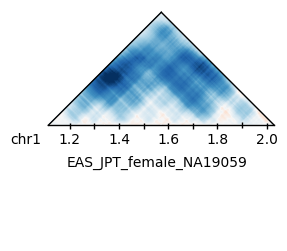

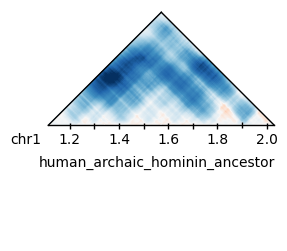

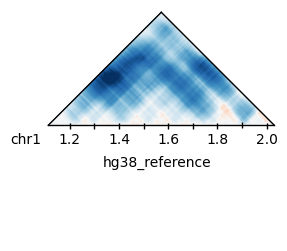

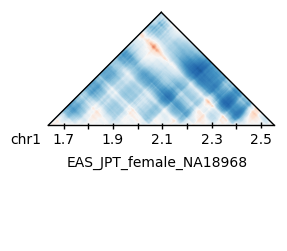

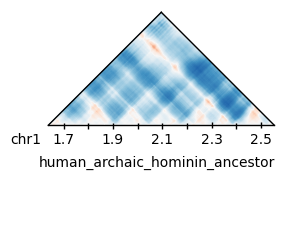

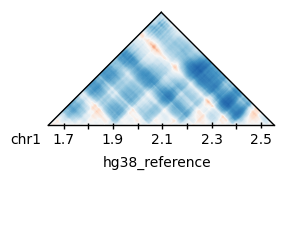

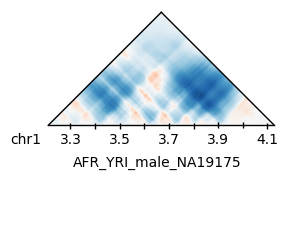

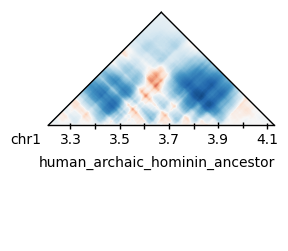

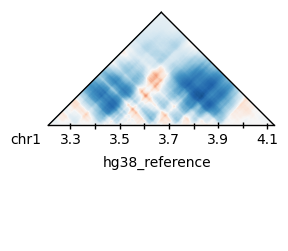

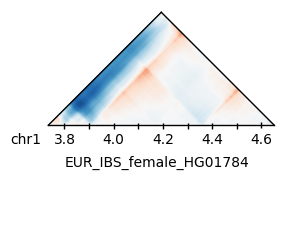

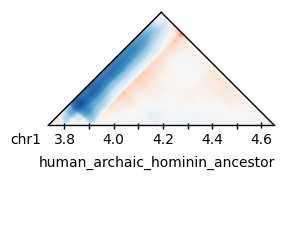

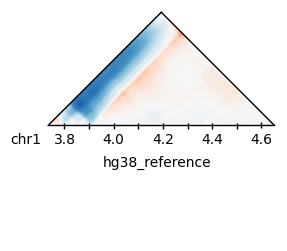

In [95]:
for w in windows:
    print(w)
    maxind = most_div_ind_per_window.loc[[w]].ind.values[0]

    ind_out = open((out_dir + '3d_predictions_HFF_%s.txt' % (maxind)),'w')
    anc_out = open((out_dir + '3d_predictions_HFF_%s.txt' % ('human_archaic_hominin_ancestor')),'w')
    ref_out = open((out_dir + '3d_predictions_HFF_%s.txt' % ('hg38_reference')),'w')

    ind_seq = get_1KGseq(chr=w[0], window_start=w[1], ind=maxind)
    anc_seq = get_anc_seq(chr=w[0], window_start=w[1])
    ref_seq = get_ref_seq_hg38(chr=w[0], window_start=w[1])

    ind_pred = runAkitaPreds(ind_seq)
    ind_pred = ind_pred[:,:,0][0]

    anc_pred = runAkitaPreds(anc_seq)
    anc_pred = anc_pred[:,:,0][0]

    ref_pred = runAkitaPreds(ref_seq)
    ref_pred = ref_pred[:,:,0][0]

    visualize_map(ind_pred, w[1], maxind, w[0], sat=2)
    visualize_map(anc_pred, w[1], 'human_archaic_hominin_ancestor', w[0], sat=2)
    visualize_map(ref_pred, w[1], 'hg38_reference', w[0], sat=2)

    ind_out.write(w[0] + "\t" + str(w[1]) + "\t" + "\t".join([str(x) for x in ind_pred]) + "\n")
    anc_out.write(w[0] + "\t" + str(w[1]) + "\t" + "\t".join([str(x) for x in anc_pred]) + "\n")
    ref_out.write(w[0] + "\t" + str(w[1]) + "\t" + "\t".join([str(x) for x in ref_pred]) + "\n")



In [81]:
w = windows[0]
maxind = most_div_ind_per_window.loc[[w]].ind.values[0]

In [96]:
windows

[('chr1', 1048576),
 ('chr1', 1572864),
 ('chr1', 3145728),
 ('chr1', 3670016),
 ('chr1', 4194304),
 ('chr1', 4718592),
 ('chr1', 5242880),
 ('chr1', 5767168),
 ('chr1', 6291456),
 ('chr1', 6815744),
 ('chr1', 7340032),
 ('chr1', 7864320),
 ('chr1', 8388608),
 ('chr1', 8912896),
 ('chr1', 9437184),
 ('chr1', 9961472),
 ('chr1', 10485760),
 ('chr1', 11010048),
 ('chr1', 11534336),
 ('chr1', 13107200),
 ('chr1', 13631488),
 ('chr1', 14155776),
 ('chr1', 14680064),
 ('chr1', 15204352),
 ('chr1', 15728640),
 ('chr1', 17301504),
 ('chr1', 17825792),
 ('chr1', 18350080),
 ('chr1', 18874368),
 ('chr1', 19398656),
 ('chr1', 19922944),
 ('chr1', 20447232),
 ('chr1', 20971520),
 ('chr1', 21495808),
 ('chr1', 22020096),
 ('chr1', 22544384),
 ('chr1', 23068672),
 ('chr1', 23592960),
 ('chr1', 24117248),
 ('chr1', 24641536),
 ('chr1', 25165824),
 ('chr1', 25690112),
 ('chr1', 26214400),
 ('chr1', 26738688),
 ('chr1', 27262976),
 ('chr1', 27787264),
 ('chr1', 28311552),
 ('chr1', 29884416),
 ('chr1'

In [99]:
with open('windows.txt', 'w') as wf:
    wf.write('\n'.join('%s\t%s' % x for x in windows))

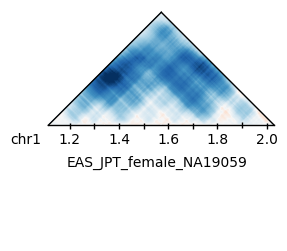

masked_array(
  data=[[nan, --, --, ..., --, --, --],
        [nan, nan, --, ..., --, --, --],
        [0.10734996199607849, nan, nan, ..., --, --, --],
        ...,
        [-0.1614825427532196, -0.19093108177185059, -0.19482818245887756,
         ..., nan, --, --],
        [-0.17743730545043945, -0.19750219583511353,
         -0.19823956489562988, ..., nan, nan, --],
        [-0.2222897708415985, -0.23767080903053284, -0.22532519698143005,
         ..., -0.09364545345306396, nan, nan]],
  mask=[[False,  True,  True, ...,  True,  True,  True],
        [False, False,  True, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False,  True,  True],
        [False, False, False, ..., False, False,  True],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20)